In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen.flow_from_directory(
    r'D:\data\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = data_gen.flow_from_directory(
    r'D:\data\val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

checkpoint_callback = ModelCheckpoint(
    'brain_classifier_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint_callback, early_stop_callback]
)

model.save('brain_classifier_final.h5')

Found 5115 images belonging to 2 classes.
Found 1279 images belonging to 2 classes.


D:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9073 - loss: 1.4949
Epoch 1: val_loss improved from inf to 3.14370, saving model to brain_classifier_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1042s 6s/step - accuracy: 0.9076 - loss: 1.4882 - val_accuracy: 0.2697 - val_loss: 3.1437
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9877 - loss: 0.0333
Epoch 2: val_loss improved from 3.14370 to 2.77210, saving model to brain_classifier_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1012s 6s/step - accuracy: 0.9877 - loss: 0.0333 - val_accuracy: 0.2697 - val_loss: 2.7721
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9910 - loss: 0.0261
Epoch 3: val_loss improved from 2.77210 to 0.75891, saving model to brain_classifier_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 997s 6s/step - accuracy: 0.9910 - loss: 0.0261 - val_accuracy: 0.3026 - val_loss: 0.7589
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9944 - loss: 0.0189
Epoch 4: val_loss im

Found 7 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 2.1453e-06
Test Accuracy: 100.00%
Test Loss: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


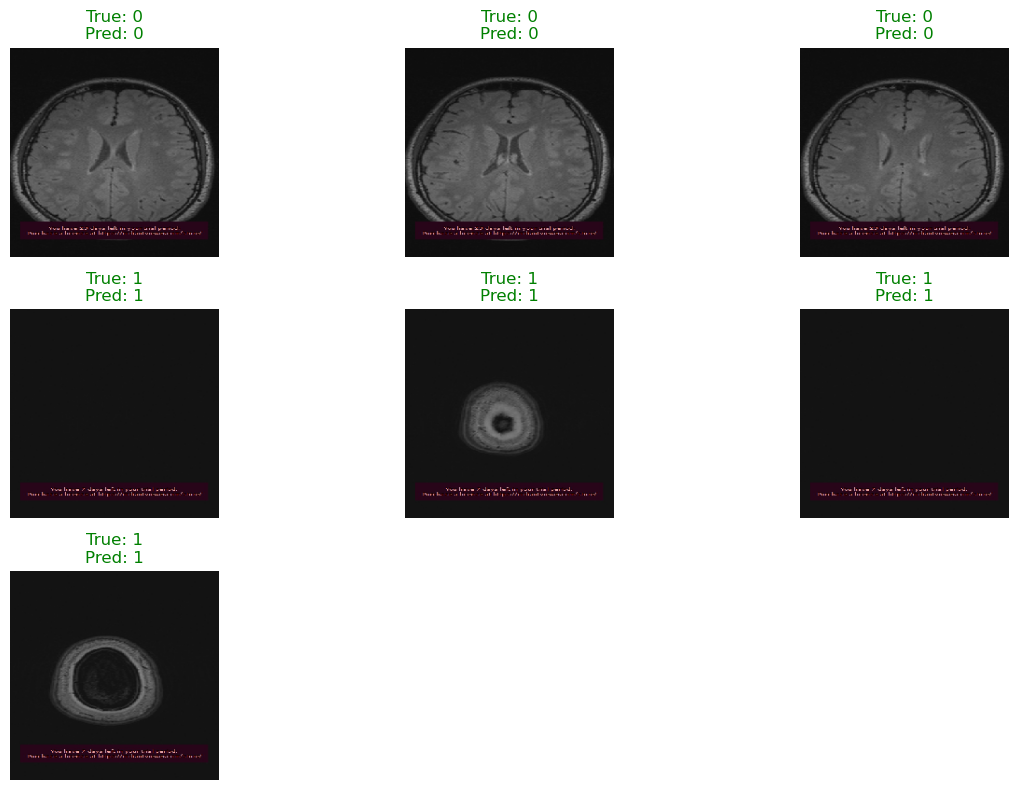

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model_path = r'D:\Brain\brain_classifier_final.h5'
model = load_model(model_path)

test_dir = r'D:\Brain\test'  

test_data_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)


test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)  

class_labels = list(test_data.class_indices.keys())

def display_predictions(test_data, predicted_classes):
    images, true_labels = next(test_data)  # Corrected line
    true_classes = true_labels.astype(int)
    
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i][0]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


display_predictions(test_data, predicted_classes)


